### Installation des dépendances

In [109]:
%pip install numpy
%pip install opencv-python
%pip install -U matplotlib
%pip install einops
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math
import os
import time
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from einops import rearrange
from PIL import Image # Using here to convert openCV image to PIL image

Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [110]:
# Define Constants
STEP_TO_NEXT_FRAME = 16 
""" in each video, we will read 1 frame every 24/STEP_TO_INDEX frames"""
DEBUG = False # if True, print debug information
NUMBER_OF_VIDEO = 100 # number of videos to index
VIDEOS_SIZE_ON_DISK = 444039168  # in octets
MAX_FRAME_NUMBER = 37895 # maximum number of frames in all video
N = int(MAX_FRAME_NUMBER/STEP_TO_NEXT_FRAME) # index Length

In [111]:
#Define all global variables
imageList = []
videoList = []
indexationTable = [] # Table of indexation
resnet_descriptor = np.empty((N, 512), dtype=np.float16) # Descriptor of the image by resnet

### Lecture des fichiers

In [112]:
imagePath = "/data/jpeg/"
videoPath = "/data/mp4/"
currDirectory = os.getcwd()
imageList = os.listdir(currDirectory + imagePath)
videoList = os.listdir(currDirectory + videoPath)

In [113]:
def getVideoParameter(videoPath:str):
    """return the frame rate and the number of frames of the video."""
    cap = cv2.VideoCapture(videoPath)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    return fps, frame_count
    

In [114]:
def cv2_to_pil(cv2_img):
    """Convert openCV image to PIL image to perfom resnet computing"""
    cv2_im_rgb = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(cv2_im_rgb)
    return pil_img

In [115]:
# Resnet-18 model loading
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)   # le modèle est chargé avec des poids pré-entrainés sur ImageNet
model = torch.nn.Sequential(*(list(model.children())[:-1]))        # supprime la dernière couche du réseau
model.eval()
if torch.cuda.is_available():  
    model.cuda() # On envoie le modèle sur le GPU

In [116]:
def ImageVectorResnet_CPU(imagePath, needToRead:bool = True):
    """Return resnet18 image descriptor"""
    if needToRead:
        image = cv2.imread(imagePath)
    else:
        image = imagePath
    
    new_image = cv2_to_pil(image)
    
    # Pre-processing
    preprocess = transforms.Compose([
    transforms.Resize((224, 224)),                       
        transforms.ToTensor(),                            
        transforms.Normalize(mean=[0.485, 0.456, 0.406],    
                         std=[0.229, 0.224, 0.225]),
    ])
    
    input_tensor = preprocess(new_image)         # 3 x 224 x 224
    input_batch = input_tensor.unsqueeze(0)  # Ajout d'une dimension de batch : 1 x 3 x 224 x 224
    
    if torch.cuda.is_available():  
        input_batch = input_batch.cuda() # On envoie le batch sur le GPU
    
    # Computing descriptor
    with torch.no_grad():
        output = model(input_batch)  # 1 x 512 x 1 x 1 


    output = rearrange(output, 'b d h w -> (b d h w)')  # 512
    output_normalized = output / torch.sum(output)
    output2_list = output_normalized.tolist()
    return output2_list

In [117]:
def plotingResnetDescriptor(descriptor:list, index_desc:int = 0):
    plt.plot(descriptor[index_desc])
    plt.title("Resnet descriptor")
    plt.show()

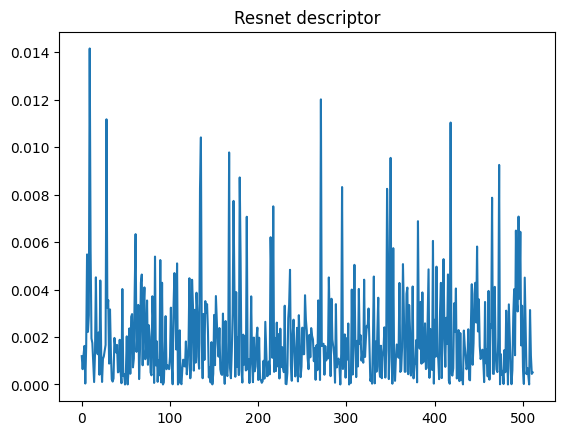

In [118]:
def createIndexTableResnet():
    """Index a video by creating a list of frames and their corresponding index. and update the indexationTable variable."""
    for video in videoList:
        path = currDirectory + videoPath + video
        fps, frame_count= getVideoParameter(path)
        cap = cv2.VideoCapture(path)
        startIndex = len(indexationTable)
        stopIndex = startIndex - 1 + math.floor(frame_count/STEP_TO_NEXT_FRAME)
        for i in range(startIndex, stopIndex):
            frameNumber = STEP_TO_NEXT_FRAME*(i-startIndex)
            indexationTable.append((frameNumber, video, (frameNumber/fps)))
            currImage = cap.set(cv2.CAP_PROP_POS_FRAMES, frameNumber)
            ret, currImage = cap.read()
            resnet_descriptor[i] = ImageVectorResnet_CPU(currImage, False)
            
 
createIndexTableResnet()       
plotingResnetDescriptor(resnet_descriptor, 1)

In [119]:
def CalculateCompressionRate():
    rate = 1- (512*len(indexationTable)*2)/VIDEOS_SIZE_ON_DISK #*2 because we use float16
    print("Le taux de compression est: ",rate)
    
CalculateCompressionRate()

Le taux de compression est:  0.9948758394214449


In [126]:
def searchImage():
    SearchResult = []
    bestIndex = 0
    for image in imageList:
        path = currDirectory + imagePath + image
        imageVector = ImageVectorResnet_CPU(path)
        for i in range(len(indexationTable)):
            # calculer la norme de la différence entre l'image et la liste de descripteurs
            # dist = np.linalg.norm(imageVector - resnet_descriptor[i])
            dist = -np.log(np.sum(np.sqrt(imageVector * resnet_descriptor[i])))
            if i == 0:
                bestDistance = dist
                bestIndex = i
            if dist < bestDistance:
                bestDistance = dist
                bestIndex = i

        if bestDistance < 0.087:
            bestVideo = indexationTable[bestIndex][1]
            bestTime = indexationTable[bestIndex][2]
        else:
            # print(image.split(".")[0], " ", bestDistance)
            bestVideo = "out"
            bestTime = ""
        # print("The best match is the frame number ", (image.split(".")[0], bestVideo.split(".")[0], bestTime)) 
        if type(bestTime) == float: 
            SearchResult.append((image.split(".")[0], bestVideo.split(".")[0], round(bestTime, 3)))
        else:
            SearchResult.append((image.split(".")[0], bestVideo.split(".")[0], bestTime)) 
        # break
    return SearchResult

SearchResult = searchImage()

In [127]:
def writeResultInCSVFile():
    """Function to write the results in a csv file."""
    with open(currDirectory+'/src/test.csv', 'w') as file:
        file.write("image,video_pred,minutage_pred\n")
        for imageName, video, time in SearchResult:
            file.write(imageName + "," + video + "," + str(time) + "\n")
    file.close()

writeResultInCSVFile()

In [128]:
# Affichage des résultats
import subprocess
directory = r'C:\Users\loicn\OneDrive - polymtl.ca\Polymtl\Session_5\INF8770_TEC_MULTIMEDIA\Lab\Lab3\src'
output = subprocess.run(['python3', 'evaluate.py', '--file', 'test.csv', '--file_gt', '../data/gt.csv'], cwd=directory, capture_output=True, text=True)

print(output.stdout)

Taux de bonnes rÃ©ponses : 95.8% (958/1000)
Ecart temporel moyen : 0.84 sec

